# Описание проекта

**Заказчик**: металлургический комбинат ООО «Так закаляем сталь»

**Цель**: уменьшить потребление электроэнергии на этапе обработки стали. 

**Этапы обработки стали**

- Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами (`data_arc.csv`)
- Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.
- Измеряют температуру стали и производят её химический анализ. (`data_temp.csv`)
- Температуру на несколько минут повышают
- Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (`data_bulk.csv`, `data_bulk_time.csv`, `data_wire.csv`, `data_wire_time.csv`)
- Продувают сплав инертным газом(`data_gas.csv`)
- Сплав перемешивают и снова проводят измерения. (`data_temp.csv`)
- Такой цикл повторяется до достижения целевого химического состава и **оптимальной температуры плавки**.
- Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки.

# Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
%config InlineBackend.figure_format = 'svg'

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["image.cmap"] = "viridis"

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 250722

In [2]:
try:
    PATH = '/datasets/final_steel/'

    df_arc = pd.read_csv(PATH + 'data_arc.csv')
    df_temp = pd.read_csv(PATH + 'data_temp.csv')
    df_bulk = pd.read_csv(PATH + 'data_bulk.csv')
    df_bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv')
    df_wire = pd.read_csv(PATH + 'data_wire.csv')
    df_wire_time = pd.read_csv(PATH + 'data_wire_time.csv')
    df_gas = pd.read_csv(PATH + 'data_gas.csv')
except:
    PATH = ''

    df_arc = pd.read_csv(PATH + 'data_arc.csv')
    df_temp = pd.read_csv(PATH + 'data_temp.csv')
    df_bulk = pd.read_csv(PATH + 'data_bulk.csv')
    df_bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv')
    df_wire = pd.read_csv(PATH + 'data_wire.csv')
    df_wire_time = pd.read_csv(PATH + 'data_wire_time.csv')
    df_gas = pd.read_csv(PATH + 'data_gas.csv')
    

## Датасеты

Для общего датафрейма нужны признаки, не связанные с таргетом. Поэтому то, что мы получили из задания, мы брать не можем (кроме, разве что, соотношения потребления активной и реактивной мощности, и то на первом подогреве). Для этого рассмотрим каждый датафрейм и выберем признаки, которые можем из них извлечь. Для удобства пойдем по хронологии обработки

### Электроды - df_arc (признак - act_react ✔️)

In [3]:
df_arc = df_arc.astype({
    'Начало нагрева дугой':'datetime64[ns]',
    'Конец нагрева дугой':'datetime64[ns]'
})

In [4]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [5]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Из описания видим отрицательную реактивную мощность с относительно большим по модулю значением, явно похоже на выброс. Посмотрим, сколько таких значений

In [6]:
df_arc[df_arc['Реактивная мощность'] < 0]['Реактивная мощность'].value_counts()

-715.504924    1
Name: Реактивная мощность, dtype: int64

Одним можно и пожертвовать

In [7]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

In [8]:
df_arc.shape

(14875, 5)

In [9]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Признак тут может получится только если как-либо поиграться с мощностями. Не думаю, что есть особая разница между тем, брать суммарную мощность, либо отношение активной к реактивной, поэтому просто выберу второй вариант. Попробуем учесть все итерации и взять среднее отношение активной мощности к реактивной

**UPD:** MAE большое, есть переобучение. Попробуем все-таки общую мощность

In [10]:
# df_arc['act/react'] = df_arc['Активная мощность'] / df_arc['Реактивная мощность']
# act_react = df_arc.groupby(['key'])[['act/react']].mean().reset_index()

df_arc['act/react'] = (df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)**(0.5)
act_react = df_arc.groupby(['key'])[['act/react']].sum().reset_index()

In [11]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
 5   act/react             14875 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 813.5 KB


In [12]:
act_react.head(10)

,key,act/react
0,1,5.826395
1,2,3.649216
2,3,2.989534
3,4,3.814962
4,5,4.035758
5,6,4.786837
6,7,2.987777
7,8,4.627389
8,9,2.555348
9,10,3.851739


### Замеры температуры - df_temp (признак - df ✔️)

In [13]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

In [14]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [15]:
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [16]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Видим, что температура есть не у всех замеров. Поскольку наш целевой признак - последняя температура, нам нужны данные, где есть и первый, и последний замер. Поэтому от сплавов с недостающими данными нужно избавиться

In [17]:
keys = set()

for i in range(len(df_temp)):
    if not np.isnan(df_temp.loc[i, 'Температура']):
        keys.add(df_temp.loc[i, 'key'])
    else:
        keys.discard(df_temp.loc[i, 'key'])

In [18]:
len(keys)

2477

In [19]:
df_temp = df_temp.query('key in @keys')

In [20]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12267 non-null  int64         
 1   Время замера  12267 non-null  datetime64[ns]
 2   Температура   12267 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


Добавляем признак - начальную температуру (температуру на первом замере)

In [21]:
df = df_temp.groupby(['key']).agg(init_temp=('Температура', 'first')).reset_index()

In [22]:
df.head()

,key,init_temp
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


In [23]:
df.shape

(2477, 2)

**Подарок от тимлида и заказчика** 

Удаляем ключи, где начальная температура < 1500, для этих случаев будет построена отдельная модель

In [24]:
df = df[df['init_temp'] >= 1500]

In [25]:
df.shape

(2473, 2)

Присоединим к нему целевой признак по пересечению ключей - так у нас не будет пропусков в итоговом датасете

In [26]:
df = df.merge(df_temp.groupby(['key']).agg(last_temp=('Температура', 'last')).reset_index(),
              how='inner', left_on='key', right_on='key')

In [27]:
df.tail(10)

,key,init_temp,last_temp
2463,2489,1613.0,1579.0
2464,2490,1602.0,1619.0
2465,2492,1618.0,1595.0
2466,2493,1599.0,1594.0
2467,2494,1585.0,1591.0
2468,2495,1570.0,1591.0
2469,2496,1554.0,1591.0
2470,2497,1571.0,1589.0
2471,2498,1591.0,1594.0
2472,2499,1569.0,1603.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2473 non-null   int64  
 1   init_temp  2473 non-null   float64
 2   last_temp  2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


Пробовал заменить на сумму засыпанного материала/проволок - плохая идея

### Сыпучие материалы - df_bulk (признак - df_bulk ✔️)

In [29]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [30]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице 15 разных материалов, которые добавляют к сплаву. Предполагаю, что материал вносит изменение в температуру сплава, поэтому хотелось бы сохранить данные. Однако не уверен, чтоит ли оставлять количество добавленного, мб стоит заменить весь объем материала на 1, а его отсутствие на 0. В любом случае, пропуски заполняем нулями (П.С. 8-й материал добавляли только один раз и в теории от него можно было бы избавиться, но пока оставим)

In [31]:
df_bulk = df_bulk.fillna(0)

In [32]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [33]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [34]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Больше придраться не к чему

### Время материалов - df_bulk_time ❌

In [35]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Здесь пока не вижу признаков, которые можно было бы вытянуть из этого датасета

### Проволка - df_wire (признак - df_wire ✔️)

In [36]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


История та же, что и с материалом

In [38]:
df_wire = df_wire.fillna(0)

In [39]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [40]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Время проволки - df_wire_time ❌

In [41]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Снова та же история, как и с материалами

### Продувание газом - df_gas (признак - df_gas ✔️)

In [42]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [43]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [44]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Думаю, пока можно так оставить

## Работа с общим датафреймом

Склеим все признаки в созданный уже датафрейм с температурами

In [45]:
df_to_merge = [act_react, df_bulk, df_wire, df_gas]

for data in df_to_merge:
    df = df.merge(data, how='inner', left_on='key', right_on='key')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2325 non-null   int64  
 1   init_temp  2325 non-null   float64
 2   last_temp  2325 non-null   float64
 3   act/react  2325 non-null   float64
 4   Bulk 1     2325 non-null   float64
 5   Bulk 2     2325 non-null   float64
 6   Bulk 3     2325 non-null   float64
 7   Bulk 4     2325 non-null   float64
 8   Bulk 5     2325 non-null   float64
 9   Bulk 6     2325 non-null   float64
 10  Bulk 7     2325 non-null   float64
 11  Bulk 8     2325 non-null   float64
 12  Bulk 9     2325 non-null   float64
 13  Bulk 10    2325 non-null   float64
 14  Bulk 11    2325 non-null   float64
 15  Bulk 12    2325 non-null   float64
 16  Bulk 13    2325 non-null   float64
 17  Bulk 14    2325 non-null   float64
 18  Bulk 15    2325 non-null   float64
 19  Wire 1     2325 non-null   float64
 20  Wire 2  

In [47]:
df.head()

,key,init_temp,last_temp,act/react,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,1613.0,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [48]:
df.rename(columns={'Газ 1': 'gas'}, inplace=True) #для красоты

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2325 non-null   int64  
 1   init_temp  2325 non-null   float64
 2   last_temp  2325 non-null   float64
 3   act/react  2325 non-null   float64
 4   Bulk 1     2325 non-null   float64
 5   Bulk 2     2325 non-null   float64
 6   Bulk 3     2325 non-null   float64
 7   Bulk 4     2325 non-null   float64
 8   Bulk 5     2325 non-null   float64
 9   Bulk 6     2325 non-null   float64
 10  Bulk 7     2325 non-null   float64
 11  Bulk 8     2325 non-null   float64
 12  Bulk 9     2325 non-null   float64
 13  Bulk 10    2325 non-null   float64
 14  Bulk 11    2325 non-null   float64
 15  Bulk 12    2325 non-null   float64
 16  Bulk 13    2325 non-null   float64
 17  Bulk 14    2325 non-null   float64
 18  Bulk 15    2325 non-null   float64
 19  Wire 1     2325 non-null   float64
 20  Wire 2  

In [50]:
y = df['last_temp']
X = df.drop(['key', 'last_temp'], axis=1)

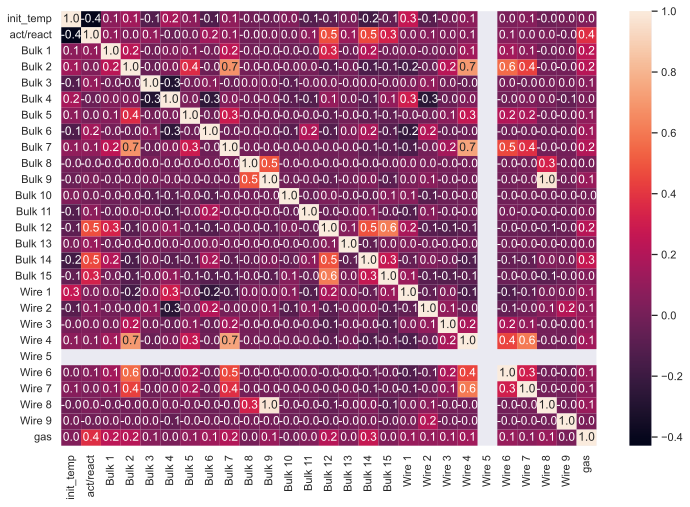

In [51]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f");

Bulk 9 сильно коррелирует с Wire 8, чуть меньше: Bulk 7 с Bulk 2 и Wire4 и Bulk 7 с Wire 4, в Wire 5 после фильтрации данных вовсе не осталось. Корреляция сильно мешает некоторым моделям, например, линейной регрессии, возможно стоит убрать какие-либо признаки

Снесем пока более приметное:Bulk 9 b Wire 5

Пока больше не придумал, что можно сделать с общим датасетам, уже бы по-тихоньку переходил к моделям

**Вопрос** На eduflow нужно выгрузить тетрадку с заданием, мне из этой версии выкинуть все, кроме задания и загрузить туда?

Судя по feature importance, Bulk 8, Wire 8, Wire 9 не влияют на таргет, попробуем их тоже убрать

**UPD:** Wire 9 таки оставляем, она чуть-чуть улучшает метрику

In [52]:
X.drop(['Bulk 9', 'Wire 5', 'Bulk 8', 'Wire 8'], axis=1, inplace=True)

In [53]:
X.shape

(2325, 23)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2325 non-null   int64  
 1   init_temp  2325 non-null   float64
 2   last_temp  2325 non-null   float64
 3   act/react  2325 non-null   float64
 4   Bulk 1     2325 non-null   float64
 5   Bulk 2     2325 non-null   float64
 6   Bulk 3     2325 non-null   float64
 7   Bulk 4     2325 non-null   float64
 8   Bulk 5     2325 non-null   float64
 9   Bulk 6     2325 non-null   float64
 10  Bulk 7     2325 non-null   float64
 11  Bulk 8     2325 non-null   float64
 12  Bulk 9     2325 non-null   float64
 13  Bulk 10    2325 non-null   float64
 14  Bulk 11    2325 non-null   float64
 15  Bulk 12    2325 non-null   float64
 16  Bulk 13    2325 non-null   float64
 17  Bulk 14    2325 non-null   float64
 18  Bulk 15    2325 non-null   float64
 19  Wire 1     2325 non-null   float64
 20  Wire 2  

# Обучение моделей

## Сравнение моделей с дефолтными гиперпараметрами

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=RANDOM_STATE)

In [56]:
%%time


MLA = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    KNeighborsRegressor(),
    CatBoostRegressor()
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', '-MAE', 'Time']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__   
    tic = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    toc = time.perf_counter()
    MLA_compare.loc[row_index, '-MAE'] = cv_results.mean()
    MLA_compare.loc[row_index, 'Time'] = toc - tic
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['-MAE'], ascending=False, inplace=True)
MLA_compare

CPU times: total: 109 ms
Wall time: 10.4 s


,Model,-MAE,Time
5,CatBoostRegressor,-6.074305,4.642013
2,RandomForestRegressor,-6.224669,1.682859
3,LGBMRegressor,-6.305296,0.255485
0,LinearRegression,-6.424706,2.694195
4,KNeighborsRegressor,-7.912457,0.046192
1,DecisionTreeRegressor,-8.638689,1.111574


## Перебор гиперпараметров

Попробуем подобрать параметры для случайного леса, бустинга и линейной регрессии

### Градиентный бустинг

In [57]:
%%time

lgbm = LGBMRegressor(random_state=RANDOM_STATE)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
max_depth = [int(x) for x in np.linspace(5, 30, num = 10)]
num_leaves = [int(x) for x in np.linspace(50, 200, num=20)]


param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'num_leaves': num_leaves,
}

rf_random = RandomizedSearchCV(estimator = lgbm, 
                               param_distributions = param_grid, 
                               n_iter = 100,
                               cv = 5, 
                               verbose=2, 
                               random_state=RANDOM_STATE,
                               scoring='neg_mean_absolute_error',
                               n_jobs = -1)

rf_random.fit(X_train, y_train)
print(rf_random.best_score_)
print(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-6.25176750059107
{'num_leaves': 89, 'n_estimators': 100, 'max_depth': 10}
CPU times: total: 2.22 s
Wall time: 40.8 s


In [58]:
lgbm = LGBMRegressor(**rf_random.best_params_)

In [59]:
print(f'Лучшая метрика: {rf_random.best_score_}, с параметрами: {rf_random.best_params_}')

Лучшая метрика: -6.25176750059107, с параметрами: {'num_leaves': 89, 'n_estimators': 100, 'max_depth': 10}


### К ближайших соседей

In [60]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 30)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring='neg_mean_absolute_error')

knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 30)},
             scoring='neg_mean_absolute_error', verbose=True)

In [61]:
print(f'Лучшая метрика: {knn_grid.best_score_}, с параметрами: {knn_grid.best_params_}')

Лучшая метрика: -6.814449082765206, с параметрами: {'knn__n_neighbors': 20}


In [62]:
knn = KNeighborsRegressor(n_neighbors=12,  n_jobs=-1)
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", knn)]
)

### Случайный лес

In [63]:
forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE)

forest_params = {'max_depth': range(1,21),
'max_features': range(2,19)}

forest_grid = GridSearchCV(forest, forest_params,
cv=5, n_jobs=-1,
verbose=True, scoring='neg_mean_absolute_error')

forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 340 candidates, totalling 1700 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=250722),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 21),
                         'max_features': range(2, 19)},
             scoring='neg_mean_absolute_error', verbose=True)

In [64]:
print(f'Лучшая метрика: {forest_grid.best_score_}, с параметрами: {forest_grid.best_params_}')

Лучшая метрика: -6.196382319947898, с параметрами: {'max_depth': 10, 'max_features': 15}


In [65]:
forest = RandomForestRegressor(**forest_grid.best_params_, n_jobs=-1, random_state=RANDOM_STATE)

Посмотрм на важность признаков

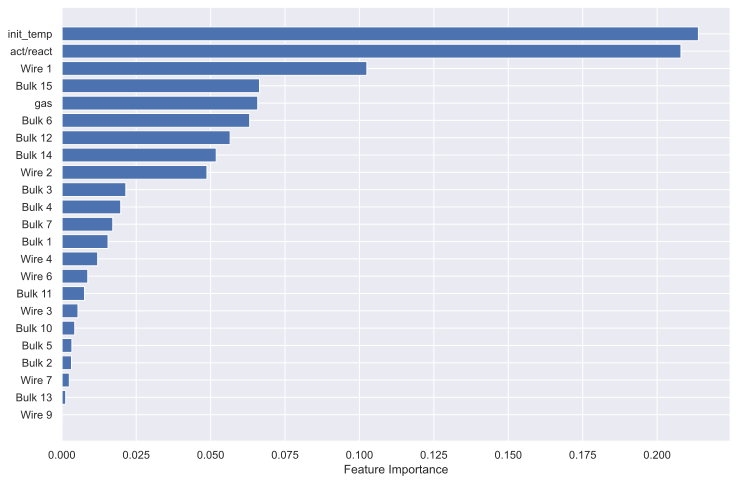

In [66]:
forest.fit(X_train, y_train)
sort = forest.feature_importances_.argsort()
plt.barh(X_train.columns[sort], forest.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.show()

### CatBoost

In [67]:
cat = CatBoostRegressor(random_state=RANDOM_STATE)

cat.fit(X_train, y_train, verbose=False)

In [68]:
cat = CatBoostRegressor(verbose=False)
cat_params = {'depth'         : [6, 8, 10, 12],
       'learning_rate' : [0.01, 0.05, 0.1],
       'iterations'    : [30, 50, 70, 100, 150]
                }

cat_gs = GridSearchCV(cat, cat_params,
                            cv=5, n_jobs=-1,
                            verbose=False, scoring='neg_mean_absolute_error')

cat_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CD9371AF10>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10, 12],
                         'iterations': [30, 50, 70, 100, 150],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_absolute_error', verbose=False)

({'depth': 7, 'iterations': 100, 'learning_rate': 0.04}, -6.842653043986084)

In [69]:
print(f'Лучшая метрика: {cat_gs.best_score_}, с параметрами: {cat_gs.best_params_}')

Лучшая метрика: -6.053578756850154, с параметрами: {'depth': 8, 'iterations': 150, 'learning_rate': 0.1}


In [70]:
cat = CatBoostRegressor(**cat_gs.best_params_, verbose=False)

### Линейная регрессия

In [71]:
lr_pipe = Pipeline(
    [("scaler", StandardScaler()), ("lr", LinearRegression(n_jobs=-1))]
)

lr_pipe.fit(X_train, y_train)

print(mean_absolute_error(y_train, lr_pipe.predict(X_train)))

6.144443902252043


In [72]:
lr_pipe = Pipeline(
    [("scaler", StandardScaler()), ("lr", LinearRegression(n_jobs=-1))]
)


# Анализ моделей

Сравним еще раз модели с новыми параметрами

## Проверка качества моделей на обучающей выборке

In [73]:
%%time


MLA = [
    lr_pipe,
    DecisionTreeRegressor(),
    forest,
    lgbm,
    knn_pipe,
    cat
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', '-MAE', 'Time']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__   
    tic = time.perf_counter()
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    toc = time.perf_counter()
    MLA_compare.loc[row_index, '-MAE'] = cv_results.mean()
    MLA_compare.loc[row_index, 'Time'] = toc - tic
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['-MAE'], ascending=False, inplace=True)
MLA_compare

CPU times: total: 328 ms
Wall time: 2.53 s


,Model,-MAE,Time
5,CatBoostRegressor,-6.053579,1.9465
2,RandomForestRegressor,-6.196382,0.360525
3,LGBMRegressor,-6.251768,0.099105
0,Pipeline,-6.424706,0.030471
4,Pipeline,-6.828606,0.048685
1,DecisionTreeRegressor,-8.616308,0.038946


В итоге кот выиграл, опробуем его на тестовых данных (П.С, здесь немного косяк, что из-за пайплайнов имена двух моделей одинаковые, но роли это особой не играет, так что оставил)

## Проверка качества лучшей модели на тестовой выборке

In [74]:
print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, cat.fit(X_train, y_train).predict(X_test))}')

Метрика MAE на тестовой выборке: 5.99976200852343


# Отчет

**Лучшая модель - CatBoostRegressor**: `итоговая метрика` оказалась равна `5.99976` со следующими `гиперпараметрами: {'depth': 8, 'iterations': 150, 'learning_rate': 0.1} (остальные - дефолтные)`

Были рассмотрены 7 датафреймов, полученные на входе:

- Из датасета с мощностью электродов был создан признак, характеризующий суммарную мощность, затраченную электродами на нагрев одного сплава стали;
- Из датасета с температурами в качестве признака взяли температуру на первой итерации для каждого сплава, в качестве целевого признака - температуру на последней итерации. В обучении модели использовались только те данные, где были оба этих признака;
- Датасет с сыпучими материалами был полностью взят как признак, все пропуски заменены нулями;
- Датасет с проволкой был принят за признак так же, как предыдущий
- Датасет с объемом газа, которым продумали сплав, был полностью добавлен как признак.

В итоговом датафрейме убрали признаки, сильно коррелирующие друг с другом. 

Затем рассмотрели 6 моделей: LGBMRegressor, KNeighborsRegressor, RandomForestRegressor, CatBoostRegressor, LinearRegression и DecisionTreeRegressor (последний скорее как дань уважения)

После перебора гиперпараметров на обучающий данных (которые составили 75% от общих) лучше всех с точки зрения минимальной абсолютной ошибки показал себя CatBoostRegressor. Эту модель прогнали на тестовых данных и получили метрику MAE = 5.99976